# Assessment of climate change at near-term (2020-2040) over Northern Europe through internal variability storylines

Analysis codes developped by Aurélien Liné and Christophe Cassou.
CECI-Cerfacs, Toulouse, France

This Jupyter Notebook requires R, with the librairies 'ncdf4', 'ismev', 'evir', 'evd', 'lubridate', and 'stringr'.
Therefore, you will need to change the 'R_path' accordingly.

# Librairies importation
## Shared libraries importation

In [1]:
import os
import time
import matplotlib.pyplot as plt
import csv
import numpy as np
import subprocess
import xarray as xr
import pandas as pd

## Personnal libraries importation

In [2]:
import cc
import cc.tools.field as ccfld

# Paths to data and figures

In [3]:
inDir = './InputData/'
storyDir = './ProducedData/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP/'
saveName = 'storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP'
R_path = '/usr/local/bin/Rscript'

# Analysis parameters

In [4]:
target = ['tas_NEU_land']
model = ['CNRM-CM6-1']
return_period = ['10']
extrema = ['min']
temporality = 'JFM'
refStr = '1995'; refEnd = '2014'; intStr = '2020'; intEnd = '2039'

significance_limit = .05; permutations = 0
confidence = None

yrStr = '1850'; yrStp = '2039'
stories = ['AN1', 'An2', 'aN3', 'an4']
period_names = ('present-day', 'near-term')
anomaly_name = 'change'
figExt = '.pdf'

# Pre-analysis routines

In [5]:
rDir = storyDir+'R_data/'
if not os.path.exists(rDir):
    os.makedirs(rDir)

In [6]:
import matplotlib
matplotlib.rcParams.update({
    'text.usetex': False, # True
    'font.family': 'sans-serif', #"Helvetica",
    #'font.fontname': 'Helvetica',
})
# Nature figure parameters
## Figure sizes
mm = 1./25.4
single_column_width = 89*mm
double_column_width = 183*mm
extended_width = 120*mm
## Font sizes
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 7})
#matplotlib.rc('font', size=5)          # controls default text sizes
#matplotlib.rc('axes', titlesize=5)     # fontsize of the axes title
#matplotlib.rc('axes', labelsize=6)    # fontsize of the x and y labels
#matplotlib.rc('xtick', labelsize=5)    # fontsize of the tick labels
#matplotlib.rc('ytick', labelsize=5)    # fontsize of the tick labels
#matplotlib.rc('legend', fontsize=5)    # legend fontsize
#matplotlib.rc('figure', titlesize=8)  # fontsize of the figure title

In [7]:
n_polygon = 7
n_filled = 1
lim = 10
point_size = 5

XX = [0]; YY = [0]
for radius in range(1, lim):
    for point in range(n_polygon):
        for theta in range(radius):
            XX.append(radius * np.cos(2 * np.pi / n_polygon * (point + theta / radius))) # + 0.125 * np.random.random())
            YY.append(radius * np.sin(2 * np.pi / n_polygon * (point + theta / radius))) # + 0.125 * np.random.random())
XX = np.array(XX)
YY = np.array(YY)
#sorted_points = np.argsort(np.sqrt(XX * XX + YY * YY))
#XX = XX[sorted_points]; YY = YY[sorted_points]
print()

In [8]:
ens_members = dict()
ens_members['CNRM-GE'] = list(xr.open_dataarray(storyDir+'Data/'+target[0]+'.nc').member.values)
for _sto in stories:
    #ens_members[_sto[:-1]] = list(xr.open_dataarray(storyDir+'Data/'+target[0]+'-'+_sto+'.nc').member.values)
    ens_members[_sto] = list(xr.open_dataarray(storyDir+'Data/'+target[0]+'-'+_sto+'.nc').member.values)
ens_members

{'CNRM-GE': ['CNRM-CM6-1_hist-ssp126_r10i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r11i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r12i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r13i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r14i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r15i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r16i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r17i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r18i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r19i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r1i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r20i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r21i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r22i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r23i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r24i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r25i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r26i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r27i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r28i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r29i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r2i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r30i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r3i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r4i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r5i1p1f2',
  'CNR

<xarray.DataArray 'sftlf' (lat: 15, lon: 32)> Size: 2kB
array([[       nan,        nan,        nan,  50.26153 ,  81.89374 ,
         95.60736 ,  68.62306 ,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [ 57.137474,  84.282486,  86.0241  ,  86.0241  , 100.      ,
        100.      ,  99.99916 , 100.      ,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,  79.16398 ,  87.83998 ,        nan,  61.52901 ,
         89.22136 ,        nan,        nan,        nan,  60.53205 ,
         94.42049 ,  66.52393 ,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
...
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
         96.728226, 100.      , 100.      , 100.      , 100.      ,
        100.      , 100.      , 100.      , 100.      , 100.      ,
        100.      , 100.      , 100.      , 100.      , 100.      ,
        100.      ,  51.887604],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,  65.94242 , 100.      , 100.      , 100.      ,
        100.      , 100.      , 100.      , 100.      , 100.      ,
        100.      ,  74.34737 ,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,  51.762886,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 120B 51.13 52.53 53.93 55.33 ... 67.94 69.34 70.74
  * lon      (lon) float64 256B -9.844 -8.438 -7.031 ... 36.56 37.97 39.38
    type     |S255 255B b'typeland'
Attributes:
    online_operation:  once
    cell_methods:      area: mean
    standard_name:     land_area_fraction
    description:       Please express "X_area_fraction" as the percentage of ...
    long_name:         Land Area Fraction
    history:           none
    units:             %
    cell_measures:     area: areacella
    lon_flip:          True

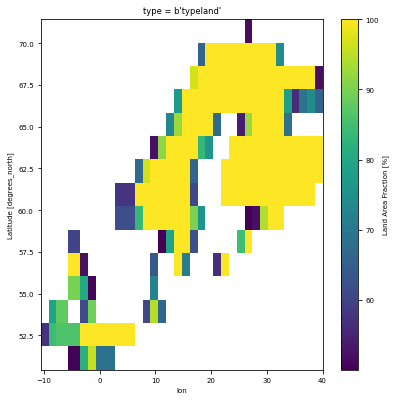

In [9]:
sftlf = cc.lon_flip(xr.open_dataset(inDir+'sftlf_fx_CNRM-CM6-1_gr.nc').sftlf)
region = ccfld.shape_to_mask(
    ccfld.get_shape(
        inDir+'AR6_WGI_referenceRegions/IPCC-WGI-reference-regions-v4.shp',
        'NEU'),
    sftlf.lat, sftlf.lon, lon_flipped=True)
mask = sftlf.where(sftlf>50.).where(region)
mask = mask.stack(position = ('lat', 'lon'))
mask = mask.dropna(dim='position')
positions = mask.position
mask = mask.unstack(dim='position').sortby(['lat', 'lon'])
mask.plot()
mask

# Beginning of the code

(If data have not already been loaded and saved as in designated files, do so.)

In [10]:
SAVE = True
# SAVE = False ; COMPUTE = False
# SAVE = False ; COMPUTE = True

if SAVE:
    COMPUTE = True

Load data.

In [13]:
begin = time.time()

if SAVE:
    for _model in model: ###
        for _target in target:
            if 'tas' in _target:
                _variable, _region, _mask_land_sea = _target.split('_')
                days_data = xr.Dataset(); tmp_days = list()
                days_map_data = xr.Dataset(); tmp_days_map = list()
                try:
                    
                    for m in ens_members['CNRM-GE']: #[:30]:
                        if 'CNRM-CM6-1' in m:
                            #yrStr, yrStp = ('1995', '2039')
                            _file = inDir+_variable+'_day_'+m+'_'+_region+_mask_land_sea+'_1850-2039.nc'
                            try:
                                print(_file)
                                tmp_days.append(xr.open_dataset(_file).get(_variable).sel(time = slice(yrStr, yrStp)))
                            except FileNotFoundError:
                                print(_target, m, 'was not loaded.')
                                pass
                            if _mask_land_sea == 'land':
                                _file = inDir+_variable+'_day_'+m+'_g1D-'+_region+_mask_land_sea+'_'+refStr+'-'+intEnd+'.nc'
                                try:
                                    print(_file)
                                    tmp_days_map.append(
                                        xr.open_dataset(_file).get(_variable).sel(
                                            time = slice(yrStr, yrStp)
                                            ).assign_coords({'position': positions, 'member': m}))
                                except FileNotFoundError:
                                    print(_target, m, 'was not loaded.')
                                    pass
                            else:
                                _file = inDir+_variable+'_day_'+m+'_gr'+_region+'_'+refStr+'-'+intEnd+'.nc'
                                try:
                                    print(_file)
                                    tmp_days_map.append(
                                        cc.lon_flip(
                                            xr.open_dataset(_file).get(_variable).sel(
                                                time = slice(yrStr, yrStp))
                                        ).where(mask>50.).stack(
                                            position = ('lat', 'lon')
                                        ).dropna(dim='position').assign_coords({'member': m}))
                                except FileNotFoundError:
                                    print(_target, m, 'was not loaded.')
                                    pass
                    days_data = days_data.assign({_variable: xr.concat(tmp_days, dim='member')})
                    days_map_data = days_map_data.assign({_variable: xr.concat(tmp_days_map, dim='member')})
                    #print(days_data)
                except ValueError:
                    print(_target+' was not available at a daily scale.')

end = time.time()
print('Runtime of the cell is', '{0:.1f}'.format(end - begin), 's')

./InputData/tas_day_CNRM-CM6-1_hist-ssp126_r10i1p1f2_NEUland_1850-2039.nc
./InputData/tas_day_CNRM-CM6-1_hist-ssp126_r10i1p1f2_g1D-NEUland_1995-2039.nc
./InputData/tas_day_CNRM-CM6-1_hist-ssp126_r11i1p1f2_NEUland_1850-2039.nc
./InputData/tas_day_CNRM-CM6-1_hist-ssp126_r11i1p1f2_g1D-NEUland_1995-2039.nc
./InputData/tas_day_CNRM-CM6-1_hist-ssp126_r12i1p1f2_NEUland_1850-2039.nc
./InputData/tas_day_CNRM-CM6-1_hist-ssp126_r12i1p1f2_g1D-NEUland_1995-2039.nc
./InputData/tas_day_CNRM-CM6-1_hist-ssp126_r13i1p1f2_NEUland_1850-2039.nc
./InputData/tas_day_CNRM-CM6-1_hist-ssp126_r13i1p1f2_g1D-NEUland_1995-2039.nc
./InputData/tas_day_CNRM-CM6-1_hist-ssp126_r14i1p1f2_NEUland_1850-2039.nc
./InputData/tas_day_CNRM-CM6-1_hist-ssp126_r14i1p1f2_g1D-NEUland_1995-2039.nc
./InputData/tas_day_CNRM-CM6-1_hist-ssp126_r15i1p1f2_NEUland_1850-2039.nc
./InputData/tas_day_CNRM-CM6-1_hist-ssp126_r15i1p1f2_g1D-NEUland_1995-2039.nc
./InputData/tas_day_CNRM-CM6-1_hist-ssp126_r16i1p1f2_NEUland_1850-2039.nc
./InputData/ta

Save data.

In [14]:
begin = time.time()

if SAVE:
    for _model in model: ###
        for _variable in days_data:
            os.system('rm '+rDir+_variable+'*')

            days = days_data.get(_variable); days_map = days_map_data.get(_variable)
            days.name = _variable; days_map.name = _variable

            for _ens in ens_members:
                days.sel(member=ens_members[_ens]).to_netcdf(
                    rDir+_variable+_region+'_'+_ens+'_'+yrStr+'0101-'+yrStp+'1231.nc')
                positions = np.arange(len(days_map.position))
                for _pos in positions:
                    days_map.sel(member=ens_members[_ens]).isel(position=_pos).drop_vars('position').to_netcdf(
                        rDir+_variable+_region+'_'+_ens+'{:03d}'.format(_pos+1)+'_'+yrStr+'0101-'+yrStp+'1231.nc')

end = time.time()
print('Runtime of the cell is', '{0:.1f}'.format(end - begin), 's')

rm: ./ProducedData/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP/R_data/tas*: No such file or directory


Runtime of the cell is 71.7 s


Apply R codes to get GEV values for each saved file.

In [15]:
begin = time.time()

if COMPUTE:
    os.system('rm '+rDir+'*.R') ; os.system('rm '+rDir+'*.csv')
    for _model in model:
        for _target in target:
            _variable, _region, _mask_land_sea = _target.split('_')
            for _return_period in return_period:
                for _extremum in extrema:

                    ### Write arguments as a data frame in a .csv file and read them from the Rscript! (temporality, _return_period, confidence)
                    with open(rDir+'params.csv', 'w', encoding='UTF8', newline='') as f:
                        writer = csv.writer(f)
                        writer.writerow(['variable', 'region', 'temporality', 'return_period', 'confidence', 'extremum', 'refSrt', 'refEnd', 'intSrt', 'intEnd'])
                        writer.writerow([_variable, _region, temporality, _return_period, 1. - significance_limit, _extremum, refStr, refEnd, intStr, intEnd])
                        f.close()

                    # os.system('ln -sf ./R/*.R '+rDir)
                    os.system('cp ./R/*.R '+rDir)
                    subprocess.check_call(R_path+' GEV_storylines.R',
                                          shell=True, stdout=open('files.txt','w'), stderr=open('errors.txt','w'),
                                          cwd=rDir)

end = time.time()
print('Runtime of the cell is', '{0:.1f}'.format(end - begin), 's')

rm: ./ProducedData/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP/R_data/*.R: No such file or directory
rm: ./ProducedData/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP/R_data/*.csv: No such file or directory


Runtime of the cell is 174.9 s


Finally plot.

In [16]:
def field_median(data):
    import numpy
    import xarray
    
    _data = data.stack(position=('lat','lon')).dropna(dim='position')
    _weights = xarray.DataArray(
        [i * numpy.ones(len(data.lon)) for i in numpy.cos(numpy.deg2rad(data.lat)).values],
        dims = ('lat', 'lon'), coords = {'lat': data.lat, 'lon': data.lon}
    ).stack(position=('lat','lon')).sel(position=_data.position)

    _sorted_data = _data.sortby(_data)
    _sorted_weights = _weights.sortby(_data)

    Sn = numpy.cumsum(_sorted_weights)
    Pn = (Sn - 0.5 * _sorted_weights) / Sn[-1]

    _out = xarray.DataArray(numpy.interp(.5, Pn, _sorted_data))

    return _out

10min tas_NEU_land


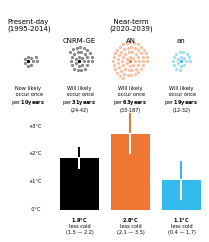

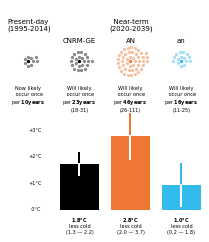

Runtime of the cell is 1.5 s


In [17]:
begin = time.time()

colors = ['black', 'black'] + ['#EE7733', '#33BBEE']

positions = mask.stack(position=('lat','lon')).dropna(dim='position').position

for _model in model:
    for _target in target:
        _variable, _region, _mask_land_sea = _target.split('_')
        for _return_period in return_period:
            for _extremum in extrema:
                
                print(str(_return_period)+_extremum, _target)

                frequency_changes = [[1, _return_period, 0,  0]]; intensity_changes = list()
                frequency_changes_li = [[1, _return_period, 0,  0]]; intensity_changes_li = list()

                for _ens in ens_members:
                    if _ens in ['CNRM-GE', 'AN1', 'an4']:
                        df = pd.read_csv(
                            rDir+_variable+_region+'_'+_ens+'_'+yrStr+'0101-'+yrStp+'1231-'+_extremum+_return_period+'.csv'
                        )
                        frequency_changes.append([1]+list(df['Frequency']))
                        intensity_changes.append(list(df['Intensity']))
                        
                        _frequency_changes_store = list(); _intensity_changes_store = list()
                        for _pos in range(len(positions)):
                            df = pd.read_csv(
                                rDir+_variable+_region+'_'+_ens+'{:03d}'.format(_pos+1)+'_'+yrStr+'0101-'+yrStp+'1231-'+_extremum+_return_period+'.csv'
                            )
                            _frequency_changes_store.append(df['Frequency'])
                            _intensity_changes_store.append(df['Intensity'])
                        _frequency_changes_da = xr.DataArray(
                            _frequency_changes_store,
                            dims=('position', 'output'),
                            coords={'position': positions, 'output': ['GEV', 'inf', 'sup']}
                        ).unstack(dim='position')
                        _intensity_changes_da = xr.DataArray(
                            _intensity_changes_store,
                            dims=('position', 'output'),
                            coords={'position': positions, 'output': ['GEV', 'inf', 'sup']}
                        ).unstack(dim='position')
                        frequency_changes_li.append(
                            [1]+[float(field_median(_frequency_changes_da.sel(output=_output))) for _output in _frequency_changes_da.output])
                        intensity_changes_li.append(
                            [float(field_median(_intensity_changes_da.sel(output=_output))) for _output in _intensity_changes_da.output])


                frequency_changes = list(np.around(np.array(frequency_changes, dtype='float')).astype(int))
                frequency_changes_li = list(np.around(np.array(frequency_changes_li, dtype='float')).astype(int))
                
                titles = [
                    period_names[0].capitalize()+'\n('+refStr+'-'+refEnd+')', '  '+period_names[1].capitalize()+'\n('+intStr+'-'+intEnd+')'
                ] + [_sto[:-1] for _sto in stories]

                datas = ['', 'CNRM-GE', 'AN', 'an']

                if _extremum == 'min':
                    _intensity_text = '\nless cold'
                elif _extremum == 'max':
                    _intensity_text = '\nhotter'
                else:
                    _intensity_text = ''
                
                figsize = (single_column_width, 100*mm)
                height_ratios = [0.5, 1., 0.2, 2.15, 0.15]

                # NOW PLOTTING 2 FIGURES WITH EACH METHOD
                
                n_cols = 4
                fig, ax = plt.subplots(5, n_cols,
                                    figsize = figsize, sharex='row', sharey='row',
                                    gridspec_kw={'height_ratios': height_ratios})

                for i in range(len(frequency_changes)):
                    if i%2==0:
                        ax[0, i].text(0, 0, titles[int(i/2)], fontsize=7)
                    ax[0, i].axis('off')
                    ax[1, i].text(0., 4.5, datas[i], fontsize=7, ha = 'center', va = 'center')
                    ax[1, i].axis('off')
                    ax[1, i].scatter(XX[:frequency_changes[i][0]], YY[:frequency_changes[i][0]],
                                    point_size, facecolors = colors[i], edgecolor = colors[i])
                    ax[1, i].scatter(XX[frequency_changes[i][0]:frequency_changes[i][1]], YY[frequency_changes[i][0]:frequency_changes[i][1]],
                                    point_size, facecolors = colors[i], edgecolor = None, alpha = 0.375)
                    #ax[1, i].scatter(XX[frequency_changes[i][2]:frequency_changes[i][3]], YY[frequency_changes[i][2]:frequency_changes[i][3]],
                    #                 point_size, facecolors = 'none', edgecolor = colors[i], alpha = 0.5)
                    ax[1, i].set_xlim(-5.,5.); ax[1, i].set_ylim(-5.,5.)

                    ax[2, i].axis('off')
                    if i == 0:
                        sentense = 'Now likely\n occur once\nper '
                        uncertainty = ''
                    else:
                        sentense = 'Will likely\n occur once\nper '
                        uncertainty = '('+str(frequency_changes[i][2])+'-'+str(frequency_changes[i][3])+')'
                    ax[2, i].text(.5, -1., sentense+r'$\bf{'+str(frequency_changes[i][1])+'  years}$\n'+uncertainty,
                                fontsize = 5, ha = 'center')

                    ax[3, i].axis('off')
                    if i == 0:
                        ax[3, i].text(0, 0, '  0°C', fontsize=5)
                        for j in range(1, int(np.max(intensity_changes))+1):
                            ax[3, i].text(0, j, '+'+str(j)+'°C', fontsize=5)
                    else:
                        ax[3, i].bar(0, intensity_changes[i-1][0], color = colors[i])
                        ax[3, i].plot([0, 0], [intensity_changes[i-1][1], intensity_changes[i-1][2]], color = colors[i], lw=2)
                        if intensity_changes[i-1][0] > 0.:
                            ax[3, i].plot([0, 0], [intensity_changes[i-1][0], max(0, intensity_changes[i-1][1])], color = 'w', lw=2)
                        else:
                            ax[3, i].plot([0, 0], [intensity_changes[i-1][0], min(0, intensity_changes[i-1][2])], color = 'w', lw=2)

                    ax[4, i].axis('off')
                    if i == 0:
                        pass
                    else:
                        ax[4, i].text(.5, 0., r'$\bf{'+str(round(intensity_changes[i-1][0],1))+'°C}$'+_intensity_text+'\n('+\
                                    str(round(intensity_changes[i-1][1],1))+' — '+str(round(intensity_changes[i-1][2],1))+')',
                                    fontsize = 5, ha = 'center', va = 'center')

                _model_save = '' if len(model) == 1 else '_'+_model

                plt.savefig(storyDir+'Figures/'+saveName+'-'+_target+'_'+str(_return_period)+_extremum+'_extremes_changes_mean_first'+_model_save+figExt)
                plt.show()
                
                fig, ax = plt.subplots(5, n_cols,
                                    figsize = figsize, sharex='row', sharey='row',
                                    gridspec_kw={'height_ratios': height_ratios})

                for i in range(len(frequency_changes_li)):
                    if i%2==0:
                        ax[0, i].text(0, 0, titles[int(i/2)], fontsize=7)
                    ax[0, i].axis('off')
                    ax[1, i].text(0., 4.5, datas[i], fontsize=7, ha = 'center', va = 'center')
                    ax[1, i].axis('off')
                    ax[1, i].scatter(XX[:frequency_changes_li[i][0]], YY[:frequency_changes_li[i][0]],
                                    point_size, facecolors = colors[i], edgecolor = colors[i])
                    ax[1, i].scatter(XX[frequency_changes_li[i][0]:frequency_changes_li[i][1]], YY[frequency_changes_li[i][0]:frequency_changes_li[i][1]],
                                    point_size, facecolors = colors[i], edgecolor = None, alpha = 0.375)
                    #ax[1, i].scatter(XX[frequency_changes_li[i][2]:frequency_changes_li[i][3]], YY[frequency_changes_li[i][2]:frequency_changes_li[i][3]],
                    #                 point_size, facecolors = 'none', edgecolor = colors[i], alpha = 0.5)
                    ax[1, i].set_xlim(-5.,5.); ax[1, i].set_ylim(-5.,5.)

                    ax[2, i].axis('off')
                    if i == 0:
                        sentense = 'Now likely\n occur once\nper '
                        uncertainty = ''
                    else:
                        sentense = 'Will likely\n occur once\nper '
                        uncertainty = '('+str(frequency_changes_li[i][2])+'-'+str(frequency_changes_li[i][3])+')'
                    ax[2, i].text(.5, -1., sentense+r'$\bf{'+str(frequency_changes_li[i][1])+'  years}$\n'+uncertainty,
                                fontsize = 5, ha = 'center')

                    ax[3, i].axis('off')
                    if i == 0:
                        ax[3, i].text(0, 0, '  0°C', fontsize=5)
                        for j in range(1, int(np.max(intensity_changes_li))+1):
                            ax[3, i].text(0, j, '+'+str(j)+'°C', fontsize=5)
                    else:
                        ax[3, i].bar(0, intensity_changes_li[i-1][0], color = colors[i])
                        ax[3, i].plot([0, 0], [intensity_changes_li[i-1][1], intensity_changes_li[i-1][2]], color = colors[i], lw=2)
                        if intensity_changes_li[i-1][0] > 0.:
                            ax[3, i].plot([0, 0], [intensity_changes_li[i-1][0], max(0, intensity_changes_li[i-1][1])], color = 'w', lw=2)
                        else:
                            ax[3, i].plot([0, 0], [intensity_changes_li[i-1][0], min(0, intensity_changes_li[i-1][2])], color = 'w', lw=2)

                    ax[4, i].axis('off')
                    if i == 0:
                        pass
                    else:
                        ax[4, i].text(.5, 0., r'$\bf{'+str(round(intensity_changes_li[i-1][0],1))+'°C}$'+_intensity_text+'\n('+\
                                    str(round(intensity_changes_li[i-1][1],1))+' — '+str(round(intensity_changes_li[i-1][2],1))+')',
                                    fontsize = 5, ha = 'center', va = 'center')

                _model_save = '' if len(model) == 1 else '_'+_model

                plt.savefig(storyDir+'Figures/'+saveName+'-'+_target+'_'+str(_return_period)+_extremum+'_extremes_changes_median_last'+_model_save+figExt)
                plt.show()

end = time.time()
print('Runtime of the cell is', '{0:.1f}'.format(end - begin), 's')

In [18]:
storyDir+'Figures/'+saveName+'-'+_target+'_'+str(_return_period)+_extremum+'_extremes_changes_median_last'+_model_save+figExt

'./ProducedData/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP/Figures/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP-tas_NEU_land_10min_extremes_changes_median_last.pdf'

In [19]:
frequency_changes, frequency_changes_li

([array([ 1, 10,  0,  0]),
  array([ 1, 31, 24, 42]),
  array([  1,  63,  33, 187]),
  array([ 1, 19, 12, 32])],
 [array([ 1, 10,  0,  0]),
  array([ 1, 23, 18, 31]),
  array([  1,  46,  26, 111]),
  array([ 1, 16, 11, 25])])

In [20]:
intensity_changes, intensity_changes_li

([[1.88094212200653, 1.5180954147999, 2.24378882921316],
  [2.7595716975557, 2.05188427461961, 3.46725912049179],
  [1.08496229183987, 0.421917028734828, 1.74800755494492]],
 [[1.7709119685902588, 1.3326886913863452, 2.195007170792752],
  [2.8210302630851904, 1.9547462531956379, 3.661931559900724],
  [0.9601570642544482, 0.18221619163619832, 1.7697334394880584]])

In [21]:
print('My work is done.')

My work is done.


In [22]:
# maplot?